In [1]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import sqlite3

from sklearn.metrics import roc_auc_score
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
# fix random seed for reproducibility
numpy.random.seed(7)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir drive
!google-drive-ocamlfuse drive


Using TensorFlow backend.


E: Package 'python-software-properties' has no installation candidate



Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

Data Preprocessing :

In [2]:
# using SQLite Table to read data.
os.chdir("/content/drive/Colab Notebooks") #changing directory
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display['COUNT(*)'].sum()

393063

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [13]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [03:14<00:00, 1790.62it/s]


In [17]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

Splitting the data :

In [0]:
from sklearn.model_selection import train_test_split
final['Text'] = preprocessed_reviews
finalp = final[final.Score == 1].sample(25000,random_state =2)
finaln = final[final.Score == 0].sample(25000,random_state =2)
finalx = pd.concat([finalp,finaln],ignore_index=True)
finalx = finalx.sort_values('Time')
y = finalx.Score.values
X = finalx.Text.values
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.2)
X_tr, X_cv , y_tr, y_cv = train_test_split(X_train,y_train,test_size=0.2)


In [0]:
from keras.preprocessing.text import Tokenizer
tokens = Tokenizer(num_words=5000)
tokens.fit_on_texts(X_tr)

X_tr = tokens.texts_to_sequences(X_tr)
X_cv = tokens.texts_to_sequences(X_cv)
X_test = tokens.texts_to_sequences(X_test)

In [20]:
print(X_tr[1])
print(type(X_tr[1]))
print(len(X_tr[1]))

[4065, 286, 4853, 83, 975, 181, 1991, 63, 2916, 867, 1467, 157, 196, 70, 1074, 60, 111, 1310, 293, 15, 3, 188, 619, 113, 62, 6, 193, 3073]
<class 'list'>
28


In [21]:
# truncate and/or pad input sequences
max_review_length = 600
X_tr = sequence.pad_sequences(X_tr, maxlen=max_review_length)
X_cv = sequence.pad_sequences(X_cv, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_tr.shape)
print(X_tr[1])
print(X_cv.shape)
print(X_cv[1])
print(X_test.shape)
print(X_test[1])

(32000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [0]:
import matplotlib.pyplot as plt
def plt_dynamic(x, vy, ty, ax, colors=['b']):
  ax.plot(x, vy, 'b', label="Validation Loss")
  ax.plot(x, ty, 'r', label="Train Loss")
  plt.legend()
  plt.grid()

SINGLE LSTM LAYER : 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 600, 32)           160032    
_________________________________________________________________
lstm_23 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 419s 13ms/step - loss: 0.3861 - acc: 0.8264 - val_loss: 0.3039 - val_acc: 0.8732
Epoch 2/10
32000/32000 [==============================] - 420s 13ms/step - loss: 0.2588 - acc: 0.8973 - val_loss: 0.3146 - val_acc: 0.8729
Epoch 3/10
32000/32000 [==============================] - 418s 13ms/

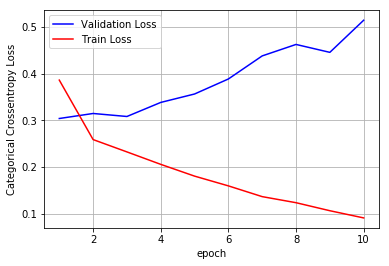

In [0]:
# create the model
embedding_vecor_length = 32
top_words = 5000
def model():
  model = Sequential()
  model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
  model.add(LSTM(100))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  #Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model
  nb_epoch = 10
  history = model.fit(X_tr, y_tr, nb_epoch=nb_epoch, batch_size=64,validation_data=(X_cv, y_cv))
  # Final evaluation of the model
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy: %.2f%%" % (scores[1]*100))
  fig,ax = plt.subplots(1,1)
  ax.set_xlabel('epoch')
  ax.set_ylabel('Categorical Crossentropy Loss')
  x = list(range(1,nb_epoch+1))
  vy = history.history['val_loss']
  ty = history.history['loss']
  plt_dynamic(x, vy, ty, ax)
model()

Model with 2 LSTM Layers and droputs:

W0702 14:55:47.630205 140006967355264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 14:55:47.667729 140006967355264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 14:55:47.674976 140006967355264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 14:55:47.968803 140006967355264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0702 14:55:47.980849 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 243,483
Trainable params: 243,483
Non-trainable params: 0
_________________________________________________________________
None

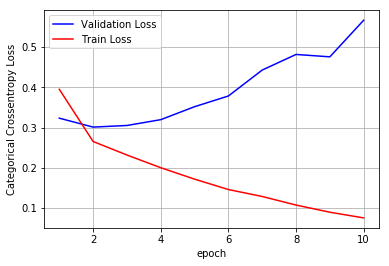

In [23]:
embedding_vecor_length = 32
top_words = 5000
def model():
  model = Sequential()
  model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
  model.add(LSTM(100,return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(50))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  #Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model
  nb_epoch = 10
  history = model.fit(X_tr, y_tr, nb_epoch=nb_epoch, batch_size=64,validation_data=(X_cv, y_cv))
  # Final evaluation of the model
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy: %.2f%%" % (scores[1]*100))
  fig,ax = plt.subplots(1,1)
  ax.set_xlabel('epoch')
  ax.set_ylabel('Categorical Crossentropy Loss')
  x = list(range(1,nb_epoch+1))
  vy = history.history['val_loss']
  ty = history.history['loss']
  plt_dynamic(x, vy, ty, ax)
model()

Model with 3 LSTM layers and dropouts(Using ReLu here): 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 600, 32)           160032    
_________________________________________________________________
lstm_51 (LSTM)               (None, 600, 100)          53200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 600, 100)          0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 600, 40)           22560     
_________________________________________________________________
dropout_35 (Dropout)         (None, 600, 40)           0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 20)                4880      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total para

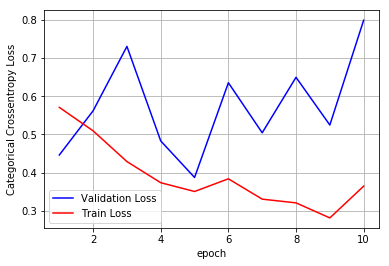

In [0]:
def model():
  model = Sequential()
  model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
  model.add(LSTM(100,return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(40,return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(20))
  model.add(Dense(1,activation='relu',kernel_initializer='he_normal'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  #Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model
  nb_epoch = 10
  history = model.fit(X_tr, y_tr, nb_epoch=nb_epoch, batch_size=64,validation_data=(X_cv, y_cv))
  # Final evaluation of the model
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy: %.2f%%" % (scores[1]*100))
  fig,ax = plt.subplots(1,1)
  ax.set_xlabel('epoch')
  ax.set_ylabel('Categorical Crossentropy Loss')
  x = list(range(1,nb_epoch+1))
  vy = history.history['val_loss']
  ty = history.history['loss']
  plt_dynamic(x, vy, ty, ax)
model()

In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = "LSTM"
x.field_names = [ "Architecture","Accuracy"]
x.add_row([ "Embedding->LSTM->Sigmoid", "85.83%" ])
x.add_row([ "Embedding->LSTM->Dropout->LSTM->Sigmoid", "85.71%"])
x.add_row(["Embedding->LSTM->Dropout->LSTM->Dropout->LSTM->ReLU", "84.19%"])
print(x)

+-----------------------------------------------------+----------+
|                     Architecture                    | Accuracy |
+-----------------------------------------------------+----------+
|               Embedding->LSTM->Sigmoid              |  85.83%  |
|       Embedding->LSTM->Dropout->LSTM->Sigmoid       |  85.71%  |
| Embedding->LSTM->Dropout->LSTM->Dropout->LSTM->ReLU |  84.19%  |
+-----------------------------------------------------+----------+


CONCLUSIONS:
 Tried 3 different achitectures: single LSTM layer, 2 LSTM layers, and 3 LSTM layers.(also used ReLu for 3rd model)

Observed that dropout decreases overfitting, but not much of a difference in these models.

Second model has the least overfitting.
